# Goal

The goal of this colab is to train a CNN on the IBM-NASA dataset for crop clasification.

# Installation

This module is dedicated for the installation of required packages for the usage of this collab.

In [1]:
!pip install segmentation-models-pytorch torch torchvision torchmetrics datasets albumentations rasterio tqdm pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 58.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Imports

In [2]:
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import time
import json


import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
from segmentation_models_pytorch import Segformer
from segmentation_models_pytorch.losses import DiceLoss, FocalLoss
from torch.utils.tensorboard import SummaryWriter


import pandas as pd

from torchmetrics.classification import Accuracy, JaccardIndex
from torchmetrics.segmentation import DiceScore, MeanIoU

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision.transforms import ToTensor
from functools import lru_cache
from tqdm import tqdm

# Dataset loading
from datasets import load_dataset

# Google Drive Configuration

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configuration

This block of code will configure all the requried global variables for the project. Some of this variables may have to be changed base on the user so make sure to check them out before executing the program.

In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 14

# Trainign
EPOCHS = 50
BATCH_SIZE = 8


# Loading
NUM_WORKERS = 0

# Model params
ENCODER_NAME = "resnet34"
ENCODER_WEIGHTS = None
LEARNING_RATE = 1e-4
DECODER_ATTENTION_TYPE = "scse"
DECODER_USER_NORM = False

# Data directories
DATA_DIR = "/content/drive/MyDrive/Universidad/TFG/Implementations/nasa_ibm/"
UNET_MODEL_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/models/"
UNET_GRAPH_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/graphs/"
UNET_METRICS_FOLDER  = "/content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/metrics/"

SPLIT_DIR = DATA_DIR + "splited"

TRAINING_IMAGE_DIR = DATA_DIR + "training_chips_merged"
TRAINING_MASK_DIR = DATA_DIR + "training_chips_mask"

VALIDATION_IMAGE_DIR = DATA_DIR + "training_chips_merged"
VALIDATION_MASK_DIR = DATA_DIR + "training_chips_mask"

TEST_IMAGE_DIR = DATA_DIR + "test_chips_merged"
TEST_MASK_DIR = DATA_DIR + "test_chips_mask"

In [5]:
class HFDGeoDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, image_dir, mask_dir, transform=None, is_original_dataset = True ):
        self.dataset = hf_dataset
        self.to_tensor = ToTensor()
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        self.chip_ids = [item['text'] for item in self.dataset]

        self.image_paths = [os.path.join(image_dir, f"{chip_id}_merged.tif")
                           for chip_id in self.chip_ids]
        self.mask_paths = [os.path.join(mask_dir, f"{chip_id}.mask.tif")
                          for chip_id in self.chip_ids]


        self.use_memmap = True

    def __len__(self):
        return len(self.dataset)

    @lru_cache(maxsize=128)  # Cache recently accessed items
    def _load_image(self, image_path):
        """Load image with caching for repeated access."""
        try:
            with rasterio.open(image_path) as src:
                if self.use_memmap:
                    # Try memory-mapped reading when possible
                    image = src.read(out_shape=src.shape, masked=False)
                else:
                    image = src.read()
                return torch.from_numpy(image).type(torch.FloatTensor)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            # Return empty tensor or handle error appropriately
            return torch.zeros((18, 224, 224), dtype=torch.float32)

    @lru_cache(maxsize=128)
    def _load_mask(self, mask_path):
        try:
            with rasterio.open(mask_path) as chip_mask:
                mask = chip_mask.read(1)
                return torch.from_numpy(mask).type(torch.LongTensor)
        except Exception as e:
            print(f"Error loading mask {mask_path}: {e}")
            return torch.zeros((224, 224), dtype=torch.long)

    def _normalize_per_band(self, image):
        normalized = np.zeros_like(image, dtype=np.float32)

        for i in range(image.shape[0]):
            band = image[i]
            band_min = band.min()
            band_max = band.max()

            if band_max > band_min:
                normalized[i] = ((band - band_min)/(band_max - band_min))
            else:
                normalized[i] = np.zeros_like(band)

        return torch.from_numpy(normalized).float()

    def __getitem__(self, idx):
        chip_id = self.dataset[idx]['text']
        image_path = self.image_paths[idx]
        mask_path  = self.mask_paths[idx]

        image = self._load_image(image_path)
        mask  = self._load_mask(mask_path)

        image = self._normalize_per_band(image)


        return image, mask





def create_datasets(dataset, image_dirs, mask_dirs, transform = None):
    # Create train and validation datasets
    train_dataset = HFDGeoDataset(
        dataset['train'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    val_dataset = HFDGeoDataset(
        dataset['validation'],
        image_dir=image_dirs,
        mask_dir=mask_dirs,
        transform=transform
    )

    return train_dataset, val_dataset

def create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE, ):
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
    )

    return train_loader, val_loader


def visualize_random_rgb_sample(dataset, bands=(2, 1, 0), figsize=(10, 5)):
    """
    Picks a random sample and displays specified bands as an RGB composite,
    with per-band min/max normalization for proper visibility.

    Args:
        dataset: your HFDGeoDataset instance
        bands (tuple of int): which bands to use for R, G, B
        figsize (tuple): figure size in inches
    """
    # 1) Pick a random index
    idx = random.randint(0, len(dataset) - 1)
    image, mask = dataset[idx]       # image: Tensor[18, H, W], mask: Tensor[H, W]

    # 2) Select just the three bands and convert to a HxWx3 NumPy array
    img_bands = image[list(bands), ...]            # shape = (3, H, W)
    img_np = img_bands.permute(1, 2, 0).numpy()    # shape = (H, W, 3)

    print( image )

    # 3) Per-band min/max normalization
    for c in range(3):
        band = img_np[..., c]
        mn, mx = band.min(), band.max()
        img_np[..., c] = (band - mn) / (mx - mn + 1e-6)

    # 4) Plot side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    ax1.imshow(img_np)
    ax1.set_title(f"Sample #{idx} RGB (bands {bands})")
    ax1.axis("off")

    ax2.imshow(mask.numpy(), cmap="gray")
    ax2.set_title("Mask")
    ax2.axis("off")

    plt.tight_layout()
    plt.show()

<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))


tensor([[[0.1563, 0.1580, 0.1580,  ..., 0.1748, 0.1472, 0.1698],
         [0.1574, 0.1586, 0.1565,  ..., 0.1346, 0.1331, 0.1574],
         [0.1593, 0.1582, 0.1550,  ..., 0.1333, 0.1511, 0.1561],
         ...,
         [0.1599, 0.1574, 0.1361,  ..., 0.2358, 0.1316, 0.2504],
         [0.1640, 0.1584, 0.1281,  ..., 0.3083, 0.1285, 0.2560],
         [0.1694, 0.1629, 0.1316,  ..., 0.3416, 0.1225, 0.2500]],

        [[0.1467, 0.1513, 0.1485,  ..., 0.1831, 0.1573, 0.1839],
         [0.1493, 0.1511, 0.1471,  ..., 0.1388, 0.1463, 0.1658],
         [0.1537, 0.1503, 0.1455,  ..., 0.1449, 0.1654, 0.1674],
         ...,
         [0.1543, 0.1503, 0.1386,  ..., 0.2698, 0.1650, 0.2869],
         [0.1604, 0.1545, 0.1320,  ..., 0.3477, 0.1678, 0.2901],
         [0.1688, 0.1628, 0.1384,  ..., 0.3757, 0.1612, 0.2827]],

        [[0.1962, 0.1994, 0.1952,  ..., 0.2127, 0.1921, 0.2273],
         [0.2012, 0.2016, 0.1945,  ..., 0.1632, 0.1855, 0.2128],
         [0.2067, 0.2020, 0.1930,  ..., 0.1771, 0.2097, 0.

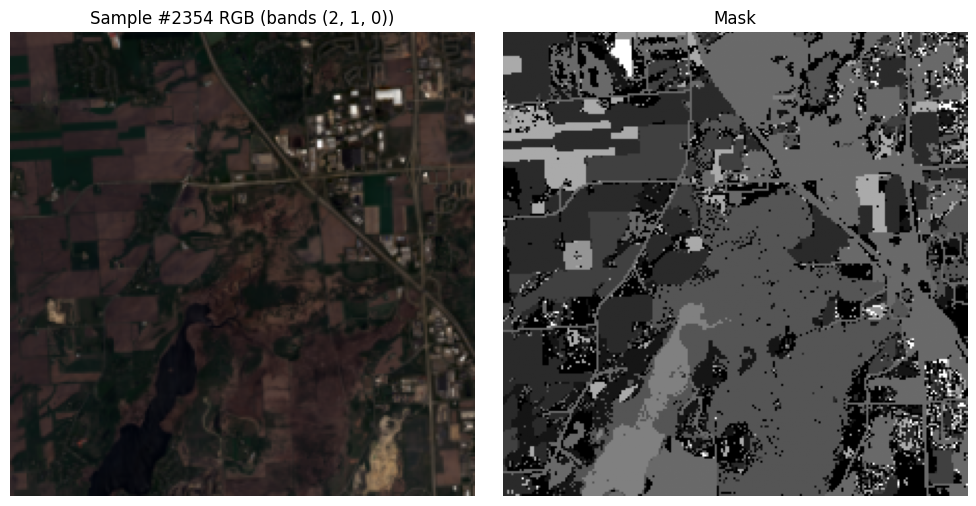

tensor([[[0.1671, 0.1599, 0.1419,  ..., 0.2916, 0.2575, 0.2401],
         [0.2533, 0.2419, 0.2275,  ..., 0.2671, 0.2503, 0.2311],
         [0.2760, 0.2695, 0.2701,  ..., 0.2593, 0.2395, 0.2359],
         ...,
         [0.2192, 0.1928, 0.1653,  ..., 0.4000, 0.5006, 0.5551],
         [0.1629, 0.1479, 0.1677,  ..., 0.3832, 0.4731, 0.5539],
         [0.1772, 0.1473, 0.1449,  ..., 0.3533, 0.3683, 0.4916]],

        [[0.1822, 0.1717, 0.1508,  ..., 0.3670, 0.3398, 0.3257],
         [0.2827, 0.2702, 0.2545,  ..., 0.3319, 0.3199, 0.2754],
         [0.3031, 0.2963, 0.2969,  ..., 0.3068, 0.2864, 0.2639],
         ...,
         [0.2351, 0.2058, 0.1634,  ..., 0.4607, 0.5764, 0.6508],
         [0.1738, 0.1487, 0.1571,  ..., 0.4476, 0.5555, 0.6565],
         [0.1644, 0.1387, 0.1366,  ..., 0.4204, 0.4377, 0.5890]],

        [[0.2021, 0.1914, 0.1669,  ..., 0.3294, 0.2774, 0.2549],
         [0.3032, 0.2941, 0.2786,  ..., 0.2996, 0.2683, 0.2513],
         [0.3191, 0.3179, 0.3203,  ..., 0.2878, 0.2517, 0.

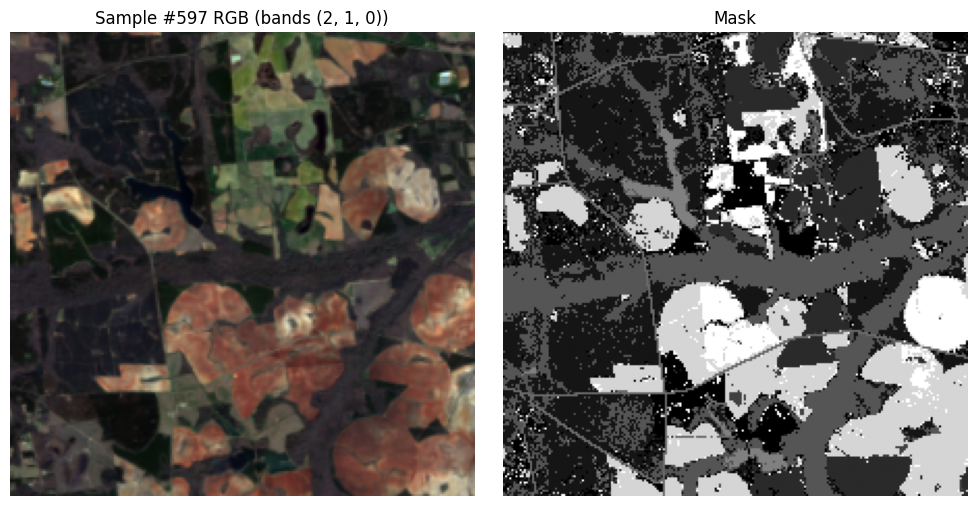

In [6]:
with open(os.path.join(SPLIT_DIR, 'dataset_splits.json')) as f:
    train_val_dataset = json.load(f)



# Create datasets
train_dataset, val_dataset = create_datasets(train_val_dataset, TRAINING_IMAGE_DIR, TRAINING_MASK_DIR)

# Create data loaders
train_loader, val_loader = create_data_loaders(train_dataset, val_dataset, batch_size=BATCH_SIZE)

visualize_random_rgb_sample(train_dataset)
visualize_random_rgb_sample(val_dataset)

In [7]:
model = Segformer(
    encoder_name=ENCODER_NAME,
    encoder_weights=ENCODER_WEIGHTS,
    in_channels=18,
    classes=NUM_CLASSES,
    decoder_attention_type=DECODER_ATTENTION_TYPE,
    decoder_use_norm=DECODER_USER_NORM
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

dice_loss = DiceLoss(mode="multiclass", from_logits=True)
focal_loss = FocalLoss(mode="multiclass", gamma=2.0)
ce_loss = nn.CrossEntropyLoss( ignore_index = 0 );


def criterion(preds, targets):
    """
    preds: raw logits,   shape [B, C, H, W]
    targets: integer labels, shape [B, H, W]
    """
    # ensure integer dtype
    targets = targets.long()

    # DiceLoss will internally one-hot `targets`
    L_dice  = dice_loss(preds, targets)
    # FocalLoss expects integer class labels
    L_focal = focal_loss(preds, targets)
    L_ce = ce_loss(preds, targets)

    return 1 * L_ce


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-7-1711369be03c>:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [8]:
accuracy = Accuracy(task="multiclass", average="macro",  num_classes=NUM_CLASSES).to(DEVICE)
iou = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES).to(DEVICE)
dice = DiceScore( num_classes=NUM_CLASSES, average="macro",   input_format="index" ).to(DEVICE)
miou = MeanIoU(num_classes=NUM_CLASSES, include_background= False,  input_format="index"  ).to(DEVICE)

Epoch 1/50:   0%|          | 0/309 [00:00<?, ?it/s]<ipython-input-5-ca4464871695>:57: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  normalized[i] = ((band - band_min)/(band_max - band_min))
Epoch 1/50: 100%|██████████| 309/309 [11:15<00:00,  2.19s/it]


[Epoch  0] Loss:  1.9971, Acc:   0.2354, IoU:   0.1437, Dice:  0.1194, mIoU:  0.0893


Epoch 1/50 [Val]: 100%|██████████| 78/78 [01:55<00:00,  1.48s/it]


[Epoch  0] Loss: 1.8420, Acc: 0.3177, IoU: 0.1941, Dice: 0.1448, mIoU: 0.1133


Epoch 2/50: 100%|██████████| 309/309 [06:00<00:00,  1.17s/it]


[Epoch  1] Loss:  1.7145, Acc:   0.3416, IoU:   0.2247, Dice:  0.1666, mIoU:  0.1321


Epoch 2/50 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.19s/it]


[Epoch  1] Loss: 1.6833, Acc: 0.3669, IoU: 0.2389, Dice: 0.1718, mIoU: 0.1388


Epoch 3/50: 100%|██████████| 309/309 [05:54<00:00,  1.15s/it]


[Epoch  2] Loss:  1.6348, Acc:   0.3711, IoU:   0.2488, Dice:  0.1856, mIoU:  0.1490


Epoch 3/50 [Val]: 100%|██████████| 78/78 [01:18<00:00,  1.00s/it]


[Epoch  2] Loss: 1.6915, Acc: 0.3639, IoU: 0.2352, Dice: 0.1797, mIoU: 0.1447


Epoch 4/50: 100%|██████████| 309/309 [05:36<00:00,  1.09s/it]


[Epoch  3] Loss:  1.5750, Acc:   0.3978, IoU:   0.2701, Dice:  0.1989, mIoU:  0.1614


Epoch 4/50 [Val]: 100%|██████████| 78/78 [01:30<00:00,  1.16s/it]


[Epoch  3] Loss: 1.6298, Acc: 0.4033, IoU: 0.2553, Dice: 0.1935, mIoU: 0.1563


Epoch 5/50: 100%|██████████| 309/309 [05:49<00:00,  1.13s/it]


[Epoch  4] Loss:  1.5325, Acc:   0.4145, IoU:   0.2835, Dice:  0.2078, mIoU:  0.1700


Epoch 5/50 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.18it/s]


[Epoch  4] Loss: 1.5849, Acc: 0.3826, IoU: 0.2604, Dice: 0.1992, mIoU: 0.1637


Epoch 6/50: 100%|██████████| 309/309 [05:54<00:00,  1.15s/it]


[Epoch  5] Loss:  1.4965, Acc:   0.4278, IoU:   0.2953, Dice:  0.2146, mIoU:  0.1767


Epoch 6/50 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.17s/it]


[Epoch  5] Loss: 1.6522, Acc: 0.3647, IoU: 0.2413, Dice: 0.1847, mIoU: 0.1521


Epoch 7/50: 100%|██████████| 309/309 [05:31<00:00,  1.07s/it]


[Epoch  6] Loss:  1.4696, Acc:   0.4387, IoU:   0.3039, Dice:  0.2205, mIoU:  0.1820


Epoch 7/50 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.17s/it]


[Epoch  6] Loss: 1.6043, Acc: 0.4013, IoU: 0.2687, Dice: 0.1973, mIoU: 0.1617


Epoch 8/50: 100%|██████████| 309/309 [05:35<00:00,  1.09s/it]


[Epoch  7] Loss:  1.4347, Acc:   0.4512, IoU:   0.3142, Dice:  0.2265, mIoU:  0.1882


Epoch 8/50 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.01s/it]


[Epoch  7] Loss: 1.4838, Acc: 0.4295, IoU: 0.2890, Dice: 0.2114, mIoU: 0.1763


Epoch 9/50: 100%|██████████| 309/309 [05:45<00:00,  1.12s/it]


[Epoch  8] Loss:  1.4165, Acc:   0.4600, IoU:   0.3216, Dice:  0.2308, mIoU:  0.1923


Epoch 9/50 [Val]: 100%|██████████| 78/78 [01:30<00:00,  1.15s/it]


[Epoch  8] Loss: 1.4689, Acc: 0.4273, IoU: 0.2930, Dice: 0.2190, mIoU: 0.1827


Epoch 10/50: 100%|██████████| 309/309 [05:32<00:00,  1.08s/it]


[Epoch  9] Loss:  1.3952, Acc:   0.4664, IoU:   0.3273, Dice:  0.2346, mIoU:  0.1965


Epoch 10/50 [Val]: 100%|██████████| 78/78 [01:15<00:00,  1.03it/s]


[Epoch  9] Loss: 1.5407, Acc: 0.4396, IoU: 0.2840, Dice: 0.2117, mIoU: 0.1724


Epoch 11/50: 100%|██████████| 309/309 [05:40<00:00,  1.10s/it]


[Epoch 10] Loss:  1.3755, Acc:   0.4732, IoU:   0.3330, Dice:  0.2374, mIoU:  0.1993


Epoch 11/50 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.17it/s]


[Epoch 10] Loss: 1.4931, Acc: 0.4380, IoU: 0.3000, Dice: 0.2163, mIoU: 0.1801


Epoch 12/50: 100%|██████████| 309/309 [05:48<00:00,  1.13s/it]


[Epoch 11] Loss:  1.3533, Acc:   0.4842, IoU:   0.3418, Dice:  0.2413, mIoU:  0.2032


Epoch 12/50 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.17s/it]


[Epoch 11] Loss: 1.4819, Acc: 0.4360, IoU: 0.3032, Dice: 0.2193, mIoU: 0.1843


Epoch 13/50: 100%|██████████| 309/309 [05:29<00:00,  1.07s/it]


[Epoch 12] Loss:  1.3233, Acc:   0.4962, IoU:   0.3522, Dice:  0.2464, mIoU:  0.2082


Epoch 13/50 [Val]: 100%|██████████| 78/78 [01:14<00:00,  1.05it/s]


[Epoch 12] Loss: 1.3661, Acc: 0.4780, IoU: 0.3323, Dice: 0.2335, mIoU: 0.1991


Epoch 14/50: 100%|██████████| 309/309 [05:41<00:00,  1.11s/it]


[Epoch 13] Loss:  1.2983, Acc:   0.5077, IoU:   0.3617, Dice:  0.2507, mIoU:  0.2135


Epoch 14/50 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.21it/s]


[Epoch 13] Loss: 1.4510, Acc: 0.4620, IoU: 0.3137, Dice: 0.2252, mIoU: 0.1858


Epoch 15/50: 100%|██████████| 309/309 [05:48<00:00,  1.13s/it]


[Epoch 14] Loss:  1.2717, Acc:   0.5192, IoU:   0.3720, Dice:  0.2554, mIoU:  0.2183


Epoch 15/50 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.18s/it]


[Epoch 14] Loss: 1.4402, Acc: 0.4525, IoU: 0.3170, Dice: 0.2270, mIoU: 0.1914


Epoch 16/50: 100%|██████████| 309/309 [05:45<00:00,  1.12s/it]


[Epoch 15] Loss:  1.2489, Acc:   0.5307, IoU:   0.3821, Dice:  0.2594, mIoU:  0.2223


Epoch 16/50 [Val]: 100%|██████████| 78/78 [01:03<00:00,  1.22it/s]


[Epoch 15] Loss: 1.4110, Acc: 0.4470, IoU: 0.3162, Dice: 0.2245, mIoU: 0.1915


Epoch 17/50: 100%|██████████| 309/309 [05:43<00:00,  1.11s/it]


[Epoch 16] Loss:  1.2158, Acc:   0.5436, IoU:   0.3938, Dice:  0.2644, mIoU:  0.2278


Epoch 17/50 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.18s/it]


[Epoch 16] Loss: 1.4039, Acc: 0.4660, IoU: 0.3238, Dice: 0.2335, mIoU: 0.1975


Epoch 18/50: 100%|██████████| 309/309 [05:25<00:00,  1.05s/it]


[Epoch 17] Loss:  1.1931, Acc:   0.5548, IoU:   0.4040, Dice:  0.2699, mIoU:  0.2333


Epoch 18/50 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 17] Loss: 1.3907, Acc: 0.4758, IoU: 0.3311, Dice: 0.2337, mIoU: 0.1972


Epoch 19/50: 100%|██████████| 309/309 [05:53<00:00,  1.15s/it]


[Epoch 18] Loss:  1.1636, Acc:   0.5682, IoU:   0.4164, Dice:  0.2754, mIoU:  0.2398


Epoch 19/50 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.21it/s]


[Epoch 18] Loss: 1.4122, Acc: 0.4611, IoU: 0.3257, Dice: 0.2341, mIoU: 0.1975


Epoch 20/50: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch 19] Loss:  1.1098, Acc:   0.5930, IoU:   0.4403, Dice:  0.2861, mIoU:  0.2517


Epoch 20/50 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 19] Loss: 1.3352, Acc: 0.4862, IoU: 0.3425, Dice: 0.2453, mIoU: 0.2098


Epoch 21/50: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 20] Loss:  1.0844, Acc:   0.6050, IoU:   0.4517, Dice:  0.2923, mIoU:  0.2587


Epoch 21/50 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.20it/s]


[Epoch 20] Loss: 1.3600, Acc: 0.4781, IoU: 0.3371, Dice: 0.2418, mIoU: 0.2062


Epoch 22/50: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 21] Loss:  1.0678, Acc:   0.6123, IoU:   0.4589, Dice:  0.2963, mIoU:  0.2630


Epoch 22/50 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 21] Loss: 1.3537, Acc: 0.4842, IoU: 0.3397, Dice: 0.2446, mIoU: 0.2075


Epoch 23/50: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 22] Loss:  1.0506, Acc:   0.6203, IoU:   0.4672, Dice:  0.3003, mIoU:  0.2677


Epoch 23/50 [Val]: 100%|██████████| 78/78 [01:05<00:00,  1.19it/s]


[Epoch 22] Loss: 1.3464, Acc: 0.4825, IoU: 0.3417, Dice: 0.2432, mIoU: 0.2062


Epoch 24/50: 100%|██████████| 309/309 [06:02<00:00,  1.17s/it]


[Epoch 23] Loss:  1.0422, Acc:   0.6255, IoU:   0.4718, Dice:  0.3038, mIoU:  0.2715


Epoch 24/50 [Val]: 100%|██████████| 78/78 [01:39<00:00,  1.27s/it]


[Epoch 23] Loss: 1.3531, Acc: 0.4782, IoU: 0.3376, Dice: 0.2445, mIoU: 0.2079


Epoch 25/50: 100%|██████████| 309/309 [05:59<00:00,  1.16s/it]


[Epoch 24] Loss:  1.0292, Acc:   0.6289, IoU:   0.4760, Dice:  0.3071, mIoU:  0.2749


Epoch 25/50 [Val]: 100%|██████████| 78/78 [01:23<00:00,  1.07s/it]


[Epoch 24] Loss: 1.3610, Acc: 0.4752, IoU: 0.3381, Dice: 0.2405, mIoU: 0.2048


Epoch 26/50: 100%|██████████| 309/309 [05:48<00:00,  1.13s/it]


[Epoch 25] Loss:  1.0188, Acc:   0.6346, IoU:   0.4815, Dice:  0.3102, mIoU:  0.2785


Epoch 26/50 [Val]: 100%|██████████| 78/78 [01:37<00:00,  1.24s/it]


[Epoch 25] Loss: 1.3620, Acc: 0.4901, IoU: 0.3446, Dice: 0.2472, mIoU: 0.2093


Epoch 27/50: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 26] Loss:  0.9969, Acc:   0.6432, IoU:   0.4906, Dice:  0.3152, mIoU:  0.2845


Epoch 27/50 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.20it/s]


[Epoch 26] Loss: 1.3398, Acc: 0.4837, IoU: 0.3435, Dice: 0.2483, mIoU: 0.2106


Epoch 28/50: 100%|██████████| 309/309 [05:51<00:00,  1.14s/it]


[Epoch 27] Loss:  0.9861, Acc:   0.6478, IoU:   0.4964, Dice:  0.3181, mIoU:  0.2880


Epoch 28/50 [Val]: 100%|██████████| 78/78 [01:31<00:00,  1.18s/it]


[Epoch 27] Loss: 1.3435, Acc: 0.4903, IoU: 0.3462, Dice: 0.2491, mIoU: 0.2107


Epoch 29/50: 100%|██████████| 309/309 [05:54<00:00,  1.15s/it]


[Epoch 28] Loss:  0.9808, Acc:   0.6506, IoU:   0.4981, Dice:  0.3203, mIoU:  0.2898


Epoch 29/50 [Val]: 100%|██████████| 78/78 [01:06<00:00,  1.16it/s]


[Epoch 28] Loss: 1.3381, Acc: 0.4879, IoU: 0.3443, Dice: 0.2498, mIoU: 0.2116


Epoch 30/50: 100%|██████████| 309/309 [05:50<00:00,  1.13s/it]


[Epoch 29] Loss:  0.9764, Acc:   0.6528, IoU:   0.5011, Dice:  0.3217, mIoU:  0.2919


Epoch 30/50 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.22s/it]


[Epoch 29] Loss: 1.3606, Acc: 0.4826, IoU: 0.3416, Dice: 0.2486, mIoU: 0.2099


Epoch 31/50: 100%|██████████| 309/309 [05:54<00:00,  1.15s/it]


[Epoch 30] Loss:  0.9712, Acc:   0.6541, IoU:   0.5024, Dice:  0.3226, mIoU:  0.2929


Epoch 31/50 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.21it/s]


[Epoch 30] Loss: 1.3472, Acc: 0.4935, IoU: 0.3462, Dice: 0.2492, mIoU: 0.2104


Epoch 32/50: 100%|██████████| 309/309 [05:50<00:00,  1.14s/it]


[Epoch 31] Loss:  0.9625, Acc:   0.6577, IoU:   0.5058, Dice:  0.3247, mIoU:  0.2951


Epoch 32/50 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 31] Loss: 1.3512, Acc: 0.4840, IoU: 0.3446, Dice: 0.2501, mIoU: 0.2118


Epoch 33/50: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch 32] Loss:  0.9516, Acc:   0.6622, IoU:   0.5109, Dice:  0.3281, mIoU:  0.2993


Epoch 33/50 [Val]: 100%|██████████| 78/78 [01:03<00:00,  1.23it/s]


[Epoch 32] Loss: 1.3462, Acc: 0.4835, IoU: 0.3432, Dice: 0.2484, mIoU: 0.2108


Epoch 34/50: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 33] Loss:  0.9511, Acc:   0.6617, IoU:   0.5106, Dice:  0.3287, mIoU:  0.2995


Epoch 34/50 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 33] Loss: 1.3396, Acc: 0.4903, IoU: 0.3476, Dice: 0.2512, mIoU: 0.2129


Epoch 35/50: 100%|██████████| 309/309 [06:01<00:00,  1.17s/it]


[Epoch 34] Loss:  0.9466, Acc:   0.6644, IoU:   0.5126, Dice:  0.3292, mIoU:  0.3005


Epoch 35/50 [Val]: 100%|██████████| 78/78 [01:07<00:00,  1.15it/s]


[Epoch 34] Loss: 1.3459, Acc: 0.4886, IoU: 0.3453, Dice: 0.2504, mIoU: 0.2118


Epoch 36/50: 100%|██████████| 309/309 [05:56<00:00,  1.15s/it]


[Epoch 35] Loss:  0.9419, Acc:   0.6651, IoU:   0.5140, Dice:  0.3305, mIoU:  0.3022


Epoch 36/50 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 35] Loss: 1.3462, Acc: 0.4787, IoU: 0.3431, Dice: 0.2489, mIoU: 0.2112


Epoch 37/50: 100%|██████████| 309/309 [05:54<00:00,  1.15s/it]


[Epoch 36] Loss:  0.9402, Acc:   0.6659, IoU:   0.5150, Dice:  0.3313, mIoU:  0.3031


Epoch 37/50 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.21it/s]


[Epoch 36] Loss: 1.3475, Acc: 0.4823, IoU: 0.3432, Dice: 0.2477, mIoU: 0.2098


Epoch 38/50: 100%|██████████| 309/309 [05:54<00:00,  1.15s/it]


[Epoch 37] Loss:  0.9383, Acc:   0.6665, IoU:   0.5159, Dice:  0.3321, mIoU:  0.3040


Epoch 38/50 [Val]: 100%|██████████| 78/78 [01:33<00:00,  1.20s/it]


[Epoch 37] Loss: 1.3420, Acc: 0.4888, IoU: 0.3469, Dice: 0.2504, mIoU: 0.2107


Epoch 39/50: 100%|██████████| 309/309 [05:20<00:00,  1.04s/it]


[Epoch 38] Loss:  0.9357, Acc:   0.6688, IoU:   0.5177, Dice:  0.3331, mIoU:  0.3048


Epoch 39/50 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 38] Loss: 1.3531, Acc: 0.4824, IoU: 0.3443, Dice: 0.2478, mIoU: 0.2101


Epoch 40/50: 100%|██████████| 309/309 [05:54<00:00,  1.15s/it]


[Epoch 39] Loss:  0.9318, Acc:   0.6701, IoU:   0.5191, Dice:  0.3341, mIoU:  0.3061


Epoch 40/50 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 39] Loss: 1.3465, Acc: 0.4863, IoU: 0.3456, Dice: 0.2499, mIoU: 0.2115


Epoch 41/50: 100%|██████████| 309/309 [05:37<00:00,  1.09s/it]


[Epoch 40] Loss:  0.9311, Acc:   0.6700, IoU:   0.5192, Dice:  0.3340, mIoU:  0.3059


Epoch 41/50 [Val]: 100%|██████████| 78/78 [01:22<00:00,  1.06s/it]


[Epoch 40] Loss: 1.3448, Acc: 0.4913, IoU: 0.3461, Dice: 0.2514, mIoU: 0.2125


Epoch 42/50: 100%|██████████| 309/309 [06:01<00:00,  1.17s/it]


[Epoch 41] Loss:  0.9290, Acc:   0.6708, IoU:   0.5200, Dice:  0.3346, mIoU:  0.3069


Epoch 42/50 [Val]: 100%|██████████| 78/78 [01:34<00:00,  1.21s/it]


[Epoch 41] Loss: 1.3425, Acc: 0.4893, IoU: 0.3462, Dice: 0.2516, mIoU: 0.2129


Epoch 43/50: 100%|██████████| 309/309 [05:55<00:00,  1.15s/it]


[Epoch 42] Loss:  0.9273, Acc:   0.6709, IoU:   0.5207, Dice:  0.3348, mIoU:  0.3071


Epoch 43/50 [Val]: 100%|██████████| 78/78 [01:04<00:00,  1.22it/s]


[Epoch 42] Loss: 1.3546, Acc: 0.4869, IoU: 0.3435, Dice: 0.2499, mIoU: 0.2115


Epoch 44/50: 100%|██████████| 309/309 [05:48<00:00,  1.13s/it]


[Epoch 43] Loss:  0.9290, Acc:   0.6718, IoU:   0.5212, Dice:  0.3356, mIoU:  0.3079


Epoch 44/50 [Val]: 100%|██████████| 78/78 [01:29<00:00,  1.15s/it]


[Epoch 43] Loss: 1.3643, Acc: 0.4824, IoU: 0.3409, Dice: 0.2487, mIoU: 0.2104


Epoch 45/50: 100%|██████████| 309/309 [05:27<00:00,  1.06s/it]


[Epoch 44] Loss:  0.9252, Acc:   0.6727, IoU:   0.5220, Dice:  0.3360, mIoU:  0.3084


Epoch 45/50 [Val]: 100%|██████████| 78/78 [01:17<00:00,  1.00it/s]


[Epoch 44] Loss: 1.3504, Acc: 0.4855, IoU: 0.3436, Dice: 0.2501, mIoU: 0.2115


Epoch 46/50: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch 45] Loss:  0.9253, Acc:   0.6727, IoU:   0.5224, Dice:  0.3361, mIoU:  0.3087


Epoch 46/50 [Val]: 100%|██████████| 78/78 [01:03<00:00,  1.23it/s]


[Epoch 45] Loss: 1.3469, Acc: 0.4883, IoU: 0.3457, Dice: 0.2507, mIoU: 0.2118


Epoch 47/50: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 46] Loss:  0.9228, Acc:   0.6731, IoU:   0.5225, Dice:  0.3359, mIoU:  0.3082


Epoch 47/50 [Val]: 100%|██████████| 78/78 [01:32<00:00,  1.18s/it]


[Epoch 46] Loss: 1.3468, Acc: 0.4864, IoU: 0.3443, Dice: 0.2501, mIoU: 0.2116


Epoch 48/50: 100%|██████████| 309/309 [05:57<00:00,  1.16s/it]


[Epoch 47] Loss:  0.9200, Acc:   0.6739, IoU:   0.5236, Dice:  0.3369, mIoU:  0.3096


Epoch 48/50 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.23s/it]


[Epoch 47] Loss: 1.3474, Acc: 0.4877, IoU: 0.3446, Dice: 0.2516, mIoU: 0.2129


Epoch 49/50: 100%|██████████| 309/309 [05:25<00:00,  1.05s/it]


[Epoch 48] Loss:  0.9209, Acc:   0.6738, IoU:   0.5236, Dice:  0.3367, mIoU:  0.3095


Epoch 49/50 [Val]: 100%|██████████| 78/78 [01:36<00:00,  1.24s/it]


[Epoch 48] Loss: 1.3431, Acc: 0.4863, IoU: 0.3451, Dice: 0.2514, mIoU: 0.2129


Epoch 50/50: 100%|██████████| 309/309 [05:58<00:00,  1.16s/it]


[Epoch 49] Loss:  0.9197, Acc:   0.6746, IoU:   0.5243, Dice:  0.3372, mIoU:  0.3099


Epoch 50/50 [Val]: 100%|██████████| 78/78 [01:19<00:00,  1.01s/it]

[Epoch 49] Loss: 1.3478, Acc: 0.4865, IoU: 0.3451, Dice: 0.2506, mIoU: 0.2122


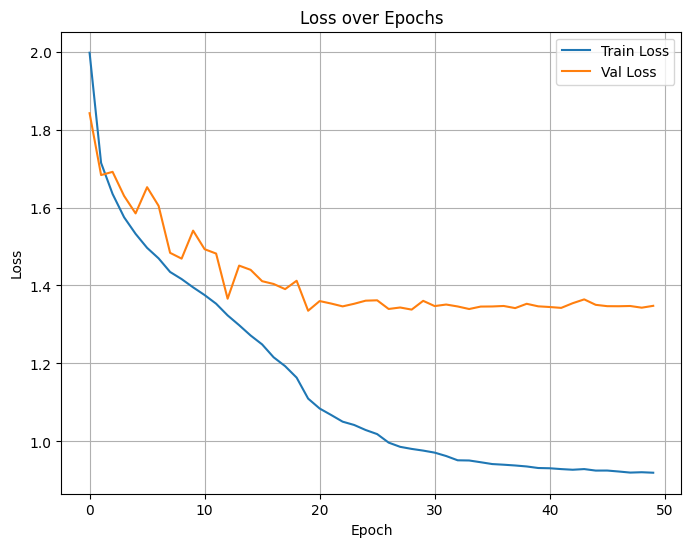

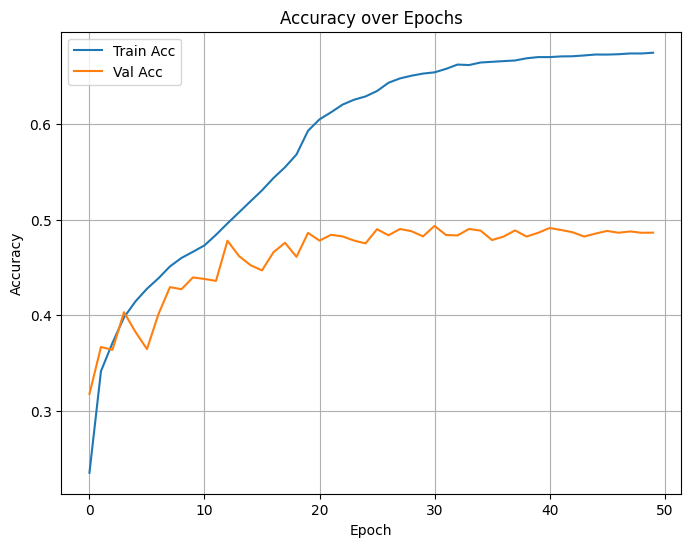

In [ ]:


writer = SummaryWriter(log_dir="runs/experiment1")

labels = {
      0: "No Data",
      1: "Natural Vegetation",
      2: "Forest",
      3: "Corn",
      4: "Soybeans",
      5: "Wetlands",
      6: "Developed Barren",
      7: "Open Water",
      8: "Winter Wheat",
      9: "Alfalfa",
      10: "Fallow Idle Cropland",
      11: "Cotton",
      12: "Sorghum",
      13: "Other"
  }

train_losses, train_accs, train_ious, train_mious, train_dices = [], [], [], [], []
val_losses,   val_accs,   val_ious,   val_mious,  val_dices = [], [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss_sum = train_acc_sum = train_iou_sum = train_dice_sum = train_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    ### ——— TRAIN ———
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)

        accuracy.update(preds, masks)
        iou      .update(preds, masks)
        dice     .update(preds, masks)
        miou     .update(preds, masks)

        train_loss_sum  += loss.item()

    # Average metrics
    train_losses.append(train_loss_sum / len(train_loader))
    train_accs  .append(accuracy.compute().item())
    train_ious  .append(iou.compute().item())
    train_dices .append(dice.compute().item())
    train_mious .append(miou.compute().item())

    writer.add_scalar('Loss/train', train_losses[-1], epoch)
    writer.add_scalar('Accuracy/train', train_accs[-1], epoch)
    writer.add_scalar('IoU/train', train_ious[-1], epoch)
    writer.add_scalar('Dice/train', train_dices[-1], epoch)
    writer.add_scalar('mIoU/train', train_mious[-1], epoch)


    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss:  {train_losses[-1]:.4f}, "
        f"Acc:   {train_accs[-1]:.4f}, "
        f"IoU:   {train_ious[-1]:.4f}, "
        f"Dice:  {train_dices[-1]:.4f}, "
        f"mIoU:  {train_mious[-1]:.4f}"
    )

    ### ——— VALIDATION ———
    model.eval()
    val_loss_sum = val_acc_sum = val_iou_sum = val_dice_sum = val_miou_sum = 0.0
    accuracy.reset(); iou.reset(); dice.reset(); miou.reset()

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Val]"):
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, masks)

            preds = torch.argmax(outputs, dim=1)

            accuracy.update(preds, masks)
            iou      .update(preds, masks)
            dice     .update(preds, masks)
            miou     .update(preds, masks)

            val_loss_sum  += loss.item()

    # Average metrics
    val_losses.append(val_loss_sum / len(val_loader))
    val_accs  .append(accuracy.compute().item())
    val_ious  .append(iou.compute().item())
    val_dices .append(dice.compute().item())
    val_mious .append(miou.compute().item())

    # Log to TensorBoard
    writer.add_scalar('Loss/val', val_losses[-1], epoch)
    writer.add_scalar('Accuracy/val', val_accs[-1], epoch)
    writer.add_scalar('IoU/val', val_ious[-1], epoch)
    writer.add_scalar('Dice/val', val_dices[-1], epoch)
    writer.add_scalar('mIoU/val', val_mious[-1], epoch)

    tqdm.write(
        f"[Epoch {epoch:>2d}] "
        f"Loss: {val_losses[-1]:.4f}, "
        f"Acc: {val_accs[-1]:.4f}, "
        f"IoU: {val_ious[-1]:.4f}, "
        f"Dice: {val_dices[-1]:.4f}, "
        f"mIoU: {val_mious[-1]:.4f}"
    )

    # Scheduler step on validation loss
    scheduler.step(val_losses[-1])

# After training, plot metrics separately
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses,   label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(train_accs,  label='Train Acc')
plt.plot(val_accs,    label='Val Acc')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Close TensorBoard writer
writer.close()


Saved Loss plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/graphs/segformer_resnet34_None_8bs_50ep_lr1e-04_loss_20250526-191257_normalized_ce.png


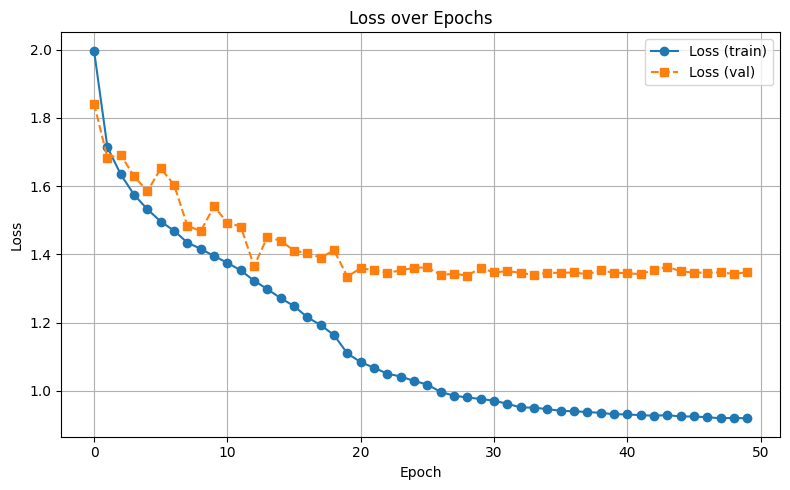

Saved Accuracy plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/graphs/segformer_resnet34_None_8bs_50ep_lr1e-04_accuracy_20250526-191257_normalized_ce.png


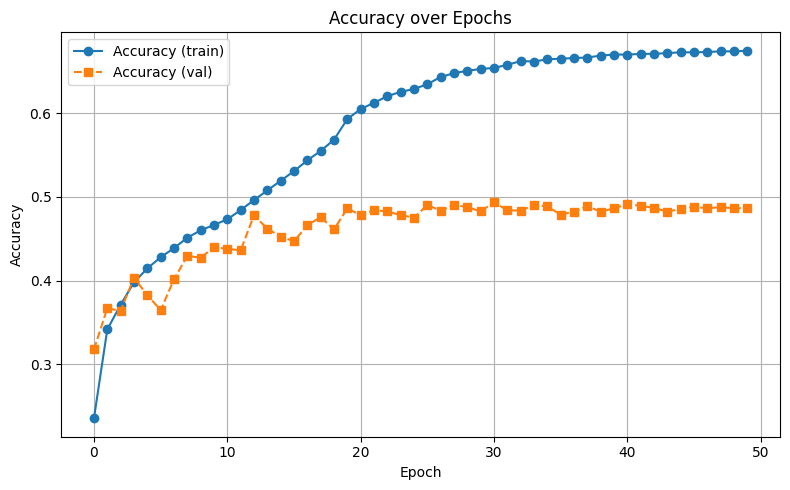

Saved Iou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/graphs/segformer_resnet34_None_8bs_50ep_lr1e-04_iou_20250526-191257_normalized_ce.png


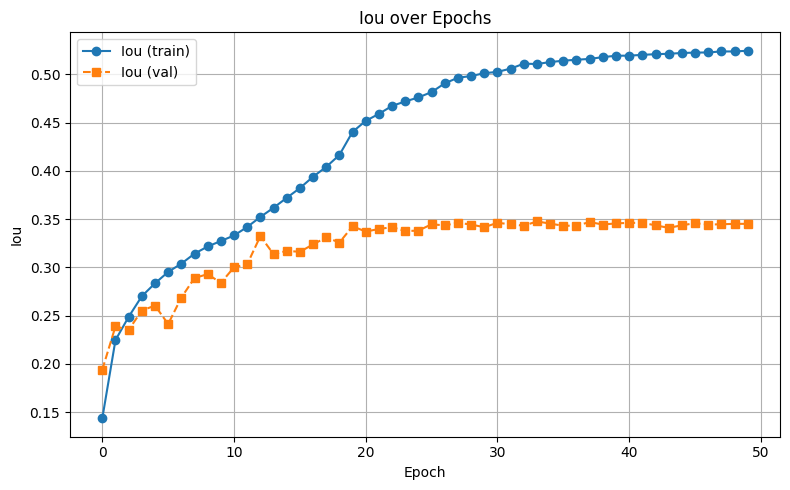

Saved Dice plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/graphs/segformer_resnet34_None_8bs_50ep_lr1e-04_dice_20250526-191257_normalized_ce.png


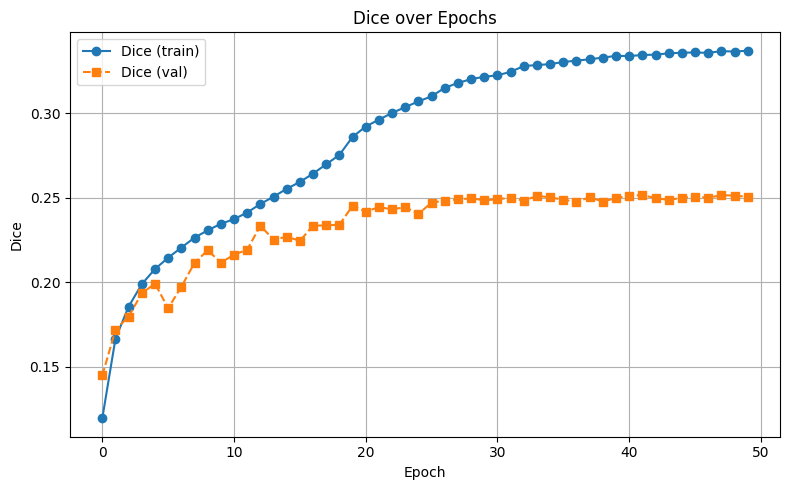

Saved Miou plot to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/graphs/segformer_resnet34_None_8bs_50ep_lr1e-04_miou_20250526-191257_normalized_ce.png


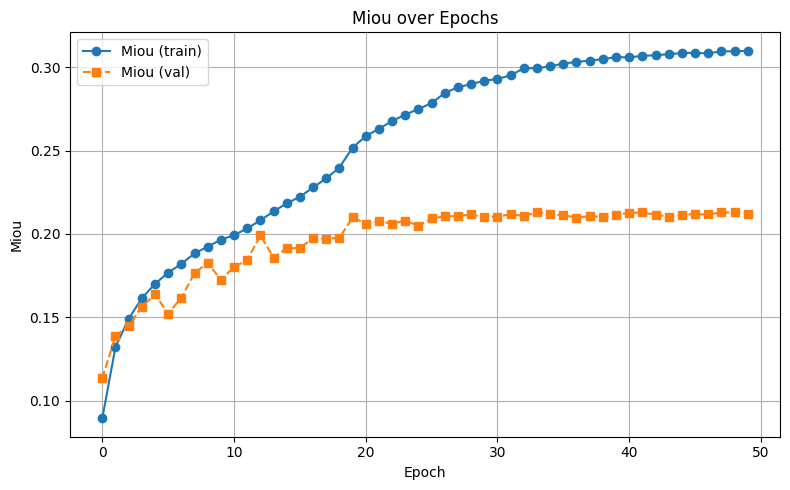

In [ ]:
timestamp = time.strftime("%Y%m%d-%H%M%S")

all_metrics = {
    'loss':  (train_losses, val_losses),
    'accuracy': (train_accs, val_accs),
    'iou':    (train_ious, val_ious),
    'dice':   (train_dices, val_dices),
    'miou':   (train_mious, val_mious),
}

for metric_name, (train_vals, val_vals) in all_metrics.items():
    plt.figure(figsize=(8, 5))
    plt.plot(train_vals, marker='o', linestyle='-', label=f'{metric_name.title()} (train)')
    plt.plot(val_vals,   marker='s', linestyle='--', label=f'{metric_name.title()} (val)')
    plt.title(f'{metric_name.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.title())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # build a descriptive filename
    filename = (
        f"segformer_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
        f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_"
        f"{metric_name}_{timestamp}_normalized_ce.png"
    )
    save_path = os.path.join(UNET_GRAPH_FOLDER, filename)

    # save and show
    plt.savefig(save_path, dpi=300)
    print(f"Saved {metric_name.title()} plot to: {save_path}")
    plt.show()

In [ ]:

os.makedirs(UNET_MODEL_FOLDER, exist_ok=True)

model_filename = (
    f"segformer_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_"
    f"lr{LEARNING_RATE:.0e}_normalized_ce.pth"
)

model_path = os.path.join(UNET_MODEL_FOLDER, model_filename)


torch.save(model.state_dict(), model_path)
print(f"Saved model checkpoint to: {model_path}")


Saved model checkpoint to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/models/segformer_resnet34_None_8bs_50ep_lr1e-04_normalized_ce.pth


In [ ]:
os.makedirs(UNET_METRICS_FOLDER, exist_ok=True)

# Build a DataFrame with both train & val metrics
metrics_df = pd.DataFrame({
    'Epoch':        list(range(1, len(train_losses) + 1)),
    'train_Loss':   train_losses,
    'train_Acc':    train_accs,
    'train_IoU':    train_ious,
    'train_Dice':   train_dices,
    'train_mIoU':   train_mious,
    'val_Loss':     val_losses,
    'val_Acc':      val_accs,
    'val_IoU':      val_ious,
    'val_Dice':     val_dices,
    'val_mIoU':     val_mious,
})

# Descriptive filename using your hyper-params
csv_filename = (
    f"segformer_{ENCODER_NAME}_{ENCODER_WEIGHTS}_"
    f"{BATCH_SIZE}bs_{EPOCHS}ep_lr{LEARNING_RATE:.0e}_normalized_ce_metrics.csv"
)
csv_path = os.path.join(UNET_METRICS_FOLDER, csv_filename)

# Save!
metrics_df.to_csv(csv_path, index=False)
print(f"Saved all train/val metrics to: {csv_path}")


Saved all train/val metrics to: /content/drive/MyDrive/Universidad/TFG/SharedFolder/DeepLearning/Segformer/metrics/segformer_resnet34_None_8bs_50ep_lr1e-04_normalized_ce_metrics.csv
